In [1]:
import open3d as o3d
import torch
import numpy as np
import objaverse
import multiprocessing
from PIL import Image
import io
from matplotlib import pyplot as plt
from os import path
import os
import shutil
from tqdm.notebook import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# transforming object

In [2]:
uid = 'fed35fa514924ff480a9d7b761f977b0'

model_annot = objaverse.load_annotations([uid])

processes = multiprocessing.cpu_count()
objects = objaverse.load_objects(uids=[uid],download_processes=processes)

model_o3d = o3d.io.read_triangle_mesh(objects[uid], True)
model_bounding_box = model_o3d.get_axis_aligned_bounding_box()

scene = 'scene0000_00'
dataset_path = '/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_3d'
scene_path = f'train/{scene}_vh_clean_2.pth'
_path = path.join(dataset_path, scene_path)    

# load 3D scene
scene_array, scene_colors, scene_annot = torch.load(_path)

scene_o3d = o3d.geometry.PointCloud()
scene_o3d.points = o3d.utility.Vector3dVector(scene_array)
scene_o3d.colors = o3d.utility.Vector3dVector(scene_colors)

scene_bounding_box = scene_o3d.get_oriented_bounding_box()

In [3]:
# transform the new object
scale_factor = 0.3 / model_bounding_box.max_bound[2]
model_o3d.scale(scale_factor, np.zeros(3))
model_bounding_box.scale(scale_factor, np.zeros(3))
model_o3d.translate(scene_bounding_box.center,relative=False)
model_o3d.translate((-1.7,-2,-0.95))
model_o3d.rotate(model_o3d.get_rotation_matrix_from_xyz((np.pi / 2,  np.pi / 9,0)), center=model_o3d.get_center())

TriangleMesh with 140 points and 92 triangles, and textures of size (512, 512) 

In [4]:
geometries = [scene_o3d,model_o3d]
#geometries = [augmented_scene_o3d]
viewer = o3d.visualization.Visualizer()
viewer.create_window()
for geometry in geometries:
    viewer.add_geometry(geometry)
opt = viewer.get_render_option()
opt.show_coordinate_frame = True
opt.background_color = np.asarray([0.5, 0.5, 0.5])
viewer.run()
viewer.destroy_window()

# exporting pc

In [14]:
# sampling points from mesh
down_model_o3d = model_o3d.sample_points_uniformly(1000)
down_model_o3d = down_model_o3d.voxel_down_sample(voxel_size=0.05)

if np.asarray(down_model_o3d.colors).size == 0:
    down_model_o3d.paint_uniform_color(np.array([0, 0, 0]))

# setting the labels of the new object points to 21.
down_model_annot = np.full(np.asarray(down_model_o3d.points).shape[0], 21.)
    
# concatenating scene and object arrays
augmented_scene_array = np.concatenate([np.asarray(scene_o3d.points), np.asarray(down_model_o3d.points)])
augmented_scene_colors = np.concatenate([np.asarray(scene_o3d.colors), np.asarray(down_model_o3d.colors)])
augmented_scene_annot = np.concatenate([scene_annot, down_model_annot])

# saving as a torch file
OUT_DIR_3D = "/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/augmented/scannet_3d"
TAG = "example"

torch.save((augmented_scene_array, augmented_scene_colors, augmented_scene_annot),
           path.join(OUT_DIR_3D, TAG, scene_path.split('/')[-1]))

# just to visualize it in here
augmented_scene_o3d = o3d.geometry.PointCloud()
augmented_scene_o3d.points = o3d.utility.Vector3dVector(augmented_scene_array)
augmented_scene_o3d.colors = o3d.utility.Vector3dVector(augmented_scene_colors)

In [ ]:
o3d.visualization.draw_geometries([augmented_scene_o3d])

In [17]:
# test if written file is correct
aug_test = torch.load(path.join(OUT_DIR_3D, TAG, scene_path.split('/')[-1]))

sample_points  = aug_test[0]
sample_colors = aug_test[1]

aug_test_pcd = o3d.geometry.PointCloud()
aug_test_pcd.points = o3d.utility.Vector3dVector(np.asarray(sample_points))
aug_test_pcd.colors = o3d.utility.Vector3dVector(np.asarray(sample_colors))

o3d.visualization.draw_geometries([aug_test_pcd])

# exporting .glb file

In [7]:
# need to export transformed object as .obj o we can read it with read_triangle_model() for rendering
o3d.io.write_triangle_mesh("/mnt/project/AT3DCV_Data/exported/mesh.obj", model_o3d)

True

In [9]:
# to check if exported object is correct
exported_mesh = o3d.io.read_triangle_mesh("/mnt/project/AT3DCV_Data/exported/mesh.obj", True)

In [10]:
exported_mesh.textures

[Image of size 512x512, with 3 channels.
 Use numpy.asarray to access buffer data.]

# projecting back (test with a certain view)

In [12]:
# http://www.open3d.org/docs/latest/python_example/visualization/index.html#render-to-image-py

scene = 'scene0000_00'
scene_img = '3420'

extrinsic_matrix = np.loadtxt(f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/pose/{scene_img}.txt')
    
intrinsic_matrix = np.loadtxt(f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/intrinsics.txt')

img_path = f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/color/{scene_img}.jpg'
depth_path = f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/depth/{scene_img}.png'

scannet_img = np.asarray(o3d.io.read_image(img_path))

scannet_depth = np.asarray(o3d.io.read_image(depth_path))

img_height, img_width = scannet_depth.shape

In [13]:
render = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)

[Open3D INFO] EGL headless mode enabled.


In [14]:
render.scene.set_background([1, 1, 1, 0])
render.scene.show_axes(True)

#white = o3d.visualization.rendering.MaterialRecord()
#white.base_color = [1.0, 1.0, 1.0, 1.0]
#white.shader = "defaultLit"

#material = o3d.visualization.rendering.MaterialRecord()
#texture = np.asarray(model_o3d.textures).copy()
#texture = o3d.geometry.Image(texture)
#material.albedo_img = texture
model_o3d.compute_triangle_normals()
model_o3d.compute_vertex_normals()

_object = o3d.io.read_triangle_model("/mnt/project/AT3DCV_Data/exported/mesh.obj")

render.scene.add_model("model", _object)

vfov = 2 * np.arctan(img_height / (2 * intrinsic_matrix[1, 1]))
eye = extrinsic_matrix[:3, 3]
lookat = eye + (extrinsic_matrix[:3, :3] @ np.array([0, 0, 1]))
up = (extrinsic_matrix[:3, :3] @ np.array([0, -1, 0]))

render.setup_camera(vfov*180/np.pi, lookat, eye, up)

In [15]:
img_model = np.asarray(render.render_to_image())
depth_model = np.asarray(render.render_to_depth_image(z_in_view_space=True)) * 1000

In [16]:
aug_depth = np.asarray(scannet_depth).copy()
aug_img = np.asarray(scannet_img).copy()

In [17]:
aug_depth_interp = aug_depth.copy()

# very simple (but not smart) interpolation of missing depth values for masking of 3d model
mask = (aug_depth==0)
aug_depth_interp[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), aug_depth[~mask])

#mask = np.all(np.array([aug_depth == 0, depth_model < np.inf]), axis=0)
#mask = np.any(np.array([aug_depth > depth_model, mask]), axis=0)

model_mask = aug_depth_interp > depth_model

aug_depth[model_mask] = depth_model[model_mask]
aug_img[model_mask] = img_model[model_mask]

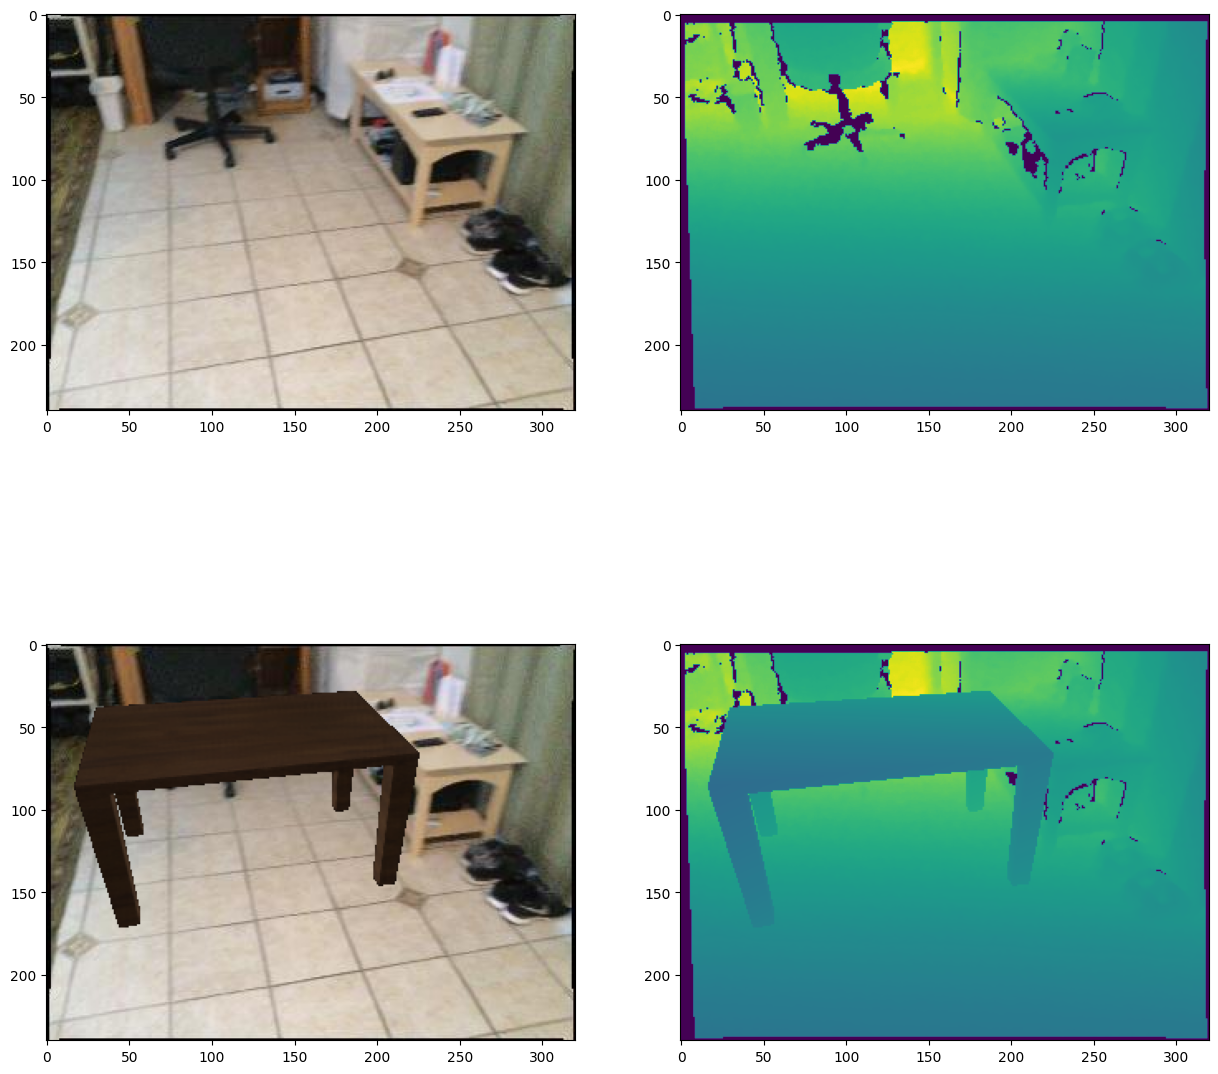

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0, 0].imshow(scannet_img)
ax[0, 1].imshow(scannet_depth)
ax[1, 0].imshow(aug_img)
ax[1, 1].imshow(aug_depth)

# project back to all views

In [2]:
# http://www.open3d.org/docs/latest/python_example/visualization/index.html#render-to-image-py
OUT_DIR_2D = "/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/augmented/scannet_2d"

scene = 'scene0000_00'
scene_img = '3420'

extrinsic_matrix = np.loadtxt(f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/pose/{scene_img}.txt')
    
intrinsic_matrix = np.loadtxt(f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/intrinsics.txt')

img_path = f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/color/{scene_img}.jpg'
depth_path = f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/depth/{scene_img}.png'

scannet_img = np.asarray(o3d.io.read_image(img_path))

scannet_depth = np.asarray(o3d.io.read_image(depth_path))

img_height, img_width = scannet_depth.shape

In [3]:
transformed_object_path = "/mnt/project/AT3DCV_Data/exported/mesh.obj"

OUT_DIR_2D = "/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/augmented/scannet_2d"
scene = 'scene0000_00'

# read intrinsics 
intrinsic_matrix = np.loadtxt(f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/intrinsics.txt')
# initialize paths
aug_scene_folder = path.join(OUT_DIR_2D,scene)
aug_color_path = path.join(aug_scene_folder, "color")
aug_depth_path = path.join(aug_scene_folder, "depth")
aug_pose_path  = path.join(aug_scene_folder, "pose")

# create folders if not exists
if not path.exists(aug_scene_folder):
   os.makedirs(aug_scene_folder)
if not path.exists(aug_color_path):
   os.makedirs(aug_color_path)
if not path.exists(aug_depth_path):
   os.makedirs(aug_depth_path)
if not path.exists(aug_pose_path):
   os.makedirs(aug_pose_path)

# original 2D data path
original_path = f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}'

# copy pose files if files does not match
ori_p_files = os.listdir(path.join(original_path,"pose"))
tgt_p_files = os.listdir(aug_pose_path)
if not tgt_p_files == ori_p_files: 
    for fname in files: shutil.copy2(os.path.join(original_pose_path,fname), aug_pose_path)


In [4]:
# list of images ids
image_ids = [_id.split(".")[0] for _id in os.listdir(path.join(original_path,"color"))]

In [5]:
# read only one to extract the size of the image so we create renderer only once at the beginning
ex_img = f'/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/{scene}/depth/{image_ids[0]}.png'
_h, _w= np.asarray(o3d.io.read_image(ex_img)).shape

In [6]:
# create renderer
render = o3d.visualization.rendering.OffscreenRenderer(_w, _h)
render.scene.set_background([1, 1, 1, 0])
render.scene.show_axes(True)
_object = o3d.io.read_triangle_model("/mnt/project/AT3DCV_Data/exported/mesh.obj")
render.scene.add_model("object", _object)

# vertical fov
vfov = 2 * np.arctan(_h / (2 * intrinsic_matrix[1, 1]))

[Open3D INFO] EGL headless mode enabled.


In [7]:
# loop over each image
_compact = "/mnt/project/AT3DCV_Data/Preprocessed_OpenScene/data/scannet_2d/"
for _id in tqdm(image_ids):
    extrinsic_matrix = np.loadtxt(f'{_compact}{scene}/pose/{_id}.txt')
    _img = np.asarray(o3d.io.read_image(f'{_compact}{scene}/color/{_id}.jpg'))
    _depth = np.asarray(o3d.io.read_image(f'{_compact}{scene}/depth/{_id}.png'))
        
    #necessary calculations for each image
    eye = extrinsic_matrix[:3, 3]
    lookat = eye + (extrinsic_matrix[:3, :3] @ np.array([0, 0, 1]))
    up = (extrinsic_matrix[:3, :3] @ np.array([0, -1, 0]))
    
    # change camera position
    render.setup_camera(vfov*180/np.pi, lookat, eye, up)
    
    img_model = np.asarray(render.render_to_image())
    depth_model = np.asarray(render.render_to_depth_image(z_in_view_space=True)) * 1000
    
    aug_depth = np.asarray(_depth).copy()
    aug_img = np.asarray(_img).copy()

    aug_depth_interp = aug_depth.copy()

    # very simple (but not smart) interpolation of missing depth values for masking of 3d model
    mask = (aug_depth==0)
    aug_depth_interp[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), aug_depth[~mask])

    #mask = np.all(np.array([aug_depth == 0, depth_model < np.inf]), axis=0)
    #mask = np.any(np.array([aug_depth > depth_model, mask]), axis=0)

    model_mask = aug_depth_interp > depth_model

    aug_depth[model_mask] = depth_model[model_mask]
    aug_img[model_mask] = img_model[model_mask]
    
    o3d.io.write_image(path.join(aug_color_path, f'{_id}.jpg'), o3d.geometry.Image(aug_img))
    o3d.io.write_image(path.join(aug_depth_path,f'{_id}.png'), o3d.geometry.Image(aug_depth))
    #print(f'{_id} is written')
    tqdm.write(f'{_id} is written', end="\r")

  0%|          | 0/279 [00:00<?, ?it/s]